In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
import pyiast as iast
import numpy as np
import ternary as tern
import math
import warnings
import numdifftools as ndt

Cory's build to enable cubic interp


In [97]:
cool_colors = {'green': (0.0, 0.716, 0.554), 'red': (1.0, 0.403, 0.397), 'blue': (0.0, 0.747, 1.0), "yellow": (0.830929, 0.793470, 0.225663), "purple": (0.745987, 0.663119, 1.000000)}

# load gas adsorption data

define set of MOFs and gases.

In [3]:
mofs = ["HKUST-1", "Co-MOF-74"]

gases = ["CH4", 
          "N2", 
         "CO2", 
         "C2H6"
        ]

In [4]:
xtal_density = {"HKUST-1" : 879.1, "Co-MOF-74" : 1172.8} # kg/m^3. see compute_density.jl

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07} # g/mol

# for plots
gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))
gas_to_label = {"CH4": "CH$_4$", "N2": "N$_2$", "CO2": "CO$_2$", "C2H6": "C$_2$H$_6$"}

read in `.csv` files containing experimental adsorption data from the literature. see the header of the `.csv` for the data source.

In [5]:
isotherm_data = dict()
for mof in mofs:
    isotherm_data[mof] = dict()
    for gas in gases:
        isotherm_data[mof][gas] = pd.read_csv("data/" + mof + "/" + gas + ".csv", comment='#')

unit conversions. goal:
* loading: mmol gas / g MOF [keep it in mmol for IAST!]
* pressure: bar

In [6]:
# special cases for each MOF
isotherm_data["HKUST-1"]["N2"]["p(bar)"] = isotherm_data["HKUST-1"]["N2"]["p(MPa)"] * 10
isotherm_data["HKUST-1"]["CH4"]["N(mmol/g)"] = isotherm_data["HKUST-1"]["CH4"]["cm3/g"] / 22.4

for gas in ["CH4", "N2", "CO2"]:
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mol/g)"] * 1000.0
    isotherm_data["Co-MOF-74"][gas]["p(bar)"] = isotherm_data["Co-MOF-74"][gas]["p(kPa)"] * 0.01
# where both MOFs need the treatment
for mof in mofs:
    # cm3 STP  *  L STP      *   mol        * 1000mmol
    #  g      1000 cm3 STP    22.4 L STP       1 mol

    isotherm_data[mof]["C2H6"]["p(bar)"] = isotherm_data[mof]["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data[mof]["C2H6"]["N(mmol/g)"] = isotherm_data[mof]["C2H6"]["N(cm3STP/cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]
    
# check for success
for mof in mofs:
    for gas in gases:
        try:
            isotherm_data[mof][gas]["N(mmol/g)"]
            isotherm_data[mof][gas]["p(bar)"]
        except KeyError:
            print("failed unit conversion! mof = ", mof, "gas = ", gas)

convert to absolute for the Co-MOF-74 data.

In [7]:
V_pore_co_mof_74 = 0.48 # cm3 / g from Table S1 here: http://www.rsc.org/suppdata/sc/c3/c3sc51319j/c3sc51319j.pdf

In [8]:
bulk_gas_density = dict() # 298 K
for gas in ["CH4", "N2", "CO2"]:
    bulk_gas_density[gas] = pd.read_csv("data/bulk_gas/" + gas + ".cgi", delimiter="\t") # read .cgi files
    
def rho_bulk(gas, p):
    # https://numpy.org/doc/stable/reference/generated/numpy.interp.html
    return np.interp(p, bulk_gas_density[gas]["Pressure (bar)"], bulk_gas_density[gas]["Density (mol/l)"])

In [9]:
# convert vol: mmol/cc = mol/L
for gas in ["CH4", "N2", "CO2"]:
    #  cm3  mol     1 L      1000 mmol
    #   g    L    1000 cm3      1 mol
    # => cm3 / g * mol / L [=] mmol/g
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] + V_pore_co_mof_74 * rho_bulk(gas, 
                                                                                                                              isotherm_data["Co-MOF-74"][gas]["p(bar)"])

plot raw data

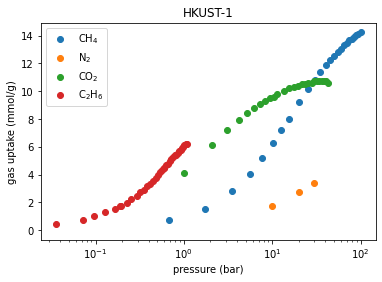

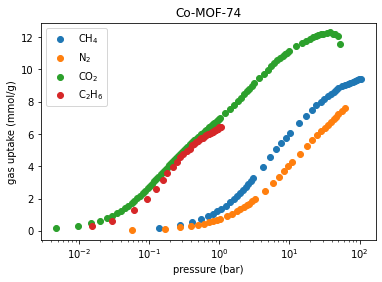

In [10]:
for mof in mofs:
    plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas_to_label[gas], color=gas_to_color[gas])
    plt.xscale("log")
    plt.title(mof)
    plt.legend()

# fit isotherm models to data for IAST

In [11]:
isotherms = dict()
for mof in mofs:
    isotherms[mof] = dict()
    for gas in gases:
        model = "Langmuir"
        if mof == "Co-MOF-74":
            if gas in ["C2H6", "CH4"]:
                model = "Quadratic"
            if gas == "CO2":
                model = "DSLangmuir"
        isotherms[mof][gas] = iast.ModelIsotherm(isotherm_data[mof][gas], 
                                                 loading_key="N(mmol/g)", pressure_key="p(bar)", model=model)

In [12]:
isotherms["Co-MOF-74"]["C2H6"].params

{'M': 3.4935519530486188, 'Ka': 4.73447976239299, 'Kb': 30.366262557965044}

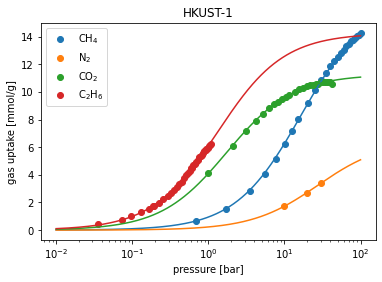

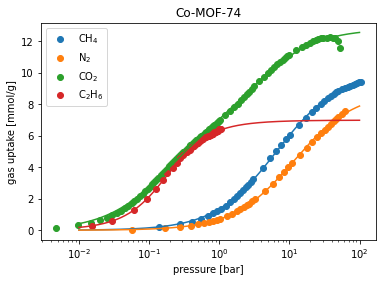

In [13]:
for mof in mofs:
    pressures = np.logspace(-2, 2, 500)
    
    plt.figure()
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas_to_label[gas], color=gas_to_color[gas])
        plt.plot(pressures, isotherms[mof][gas].loading(pressures), color=gas_to_color[gas])
    plt.xscale("log")
#     plt.xlim([0, 1])
    plt.xlabel("pressure [bar]")
    plt.ylabel("gas uptake [mmol/g]")
    plt.title(mof)
    plt.legend()

# set up single-MOF IAST calculations
to obtain $m(\mathbf{x})$, the total mass adsorbed in a given MOF with composition at pressure $\mathbf{x}$.

In [14]:
p_total = 1.0 # total pressure [bar]

In [15]:
"""
compute *total* mass of adsorbed gas in the MOF.
returns units: g gas / g MOF

# example:
mol_fxns = {'C2H6': 0.4, 'CH4': 0.6}
adsorbed_mass("HKUST-1", mol_fxns)
"""
def adsorbed_mass(mof, mol_fxns):
    # mol fractions must add to 1.0
    if ~ np.isclose(np.sum([x_i for x_i in mol_fxns.values()]), 1.0):
        raise Exception("mol fxns dont add to 1")
    
    # if any components are zero, remove that component
    mol_fxns = {gas: x_i for gas, x_i in mol_fxns.items() if x_i != 0}
    
    # if we are left with a pure gas, use the pure-component isotherm...
    if len(mol_fxns) == 1:
        gas = list(mol_fxns.keys())[0]
        return isotherms[mof][gas].loading(p_total) * mol_wts[gas] / 1000.0
    
    pressures = np.array([p_total * x_i for x_i in mol_fxns.values()])
    
    q = iast.iast(pressures, [isotherms[mof][gas] for gas in mol_fxns.keys()], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gas] for j, gas in enumerate(mol_fxns.keys())]) / 1000

In [16]:
mol_fxns = {'C2H6': 0.01, 'CH4': 0.99}
adsorbed_mass(mof, mol_fxns)

0.026933664127890507

# a single-MOF sensor

In [103]:
mof = "Co-MOF-74"

In [104]:
"""
convert mol fraction vector with contaminant mole fractions into a mol_fxn dictionary.
"""
def x_to_mol_fxns(x, contaminants):
    assert len(x) == len(contaminants)
    mol_fxns = dict()
    mol_fxns["CH4"] = 1.0 - np.sum(x)
    for i, contaminant in enumerate(contaminants):
        mol_fxns[contaminant] = x[i]
    return mol_fxns

"""
convert mole fraction dict to x
"""
def mol_fxns_to_x(mol_fxns, contaminants):
    return np.array([mol_fxns[contaminant] for contaminant in contaminants])

"""
numerically compute jacobian matrix of m(x) at a given point
"""
def jacobian_matrix_of_m(mof, mol_fxns, contaminants):
    # complicated b/c adsorbed mass takes in a dictionary.
    # construct J(x)
    J = ndt.Jacobian(lambda x: adsorbed_mass(mof, x_to_mol_fxns(x, contaminants)), step=0.001)
    
    # compute x for given mole fractions
    x = mol_fxns_to_x(mol_fxns, contaminants)
    return J(x)

### two contaminants

In [105]:
contaminants = ["C2H6", "CO2"]

create heapmap to visualize $m(\mathbf{x})$

In [106]:
delta = 0.005
x_1 = np.arange(0.00, 0.3, delta)
x_2 = np.arange(0.00, 0.3, delta)
X_1, X_2 = np.meshgrid(x_1, x_2)
M = np.zeros(np.shape(X_1))
for i in range(np.shape(X_1)[0]):
    for j in range(np.shape(X_2)[1]):
        mol_fxns = x_to_mol_fxns([x_1[i], x_2[j]], contaminants)
        M[j, i] = adsorbed_mass(mof, mol_fxns)
        
assert np.sum(np.isnan(M)) == 0

define operating point about which to linearize, compute adsorbed mass at the operating point.

In [107]:
mol_fxns_op = {"CH4": 0.85, contaminants[0]: 0.05, contaminants[1]: 0.1}
mol_fxns_op

{'CH4': 0.85, 'C2H6': 0.05, 'CO2': 0.1}

In [108]:
x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
x_op

array([0.05, 0.1 ])

In [109]:
m_op = adsorbed_mass(mof, mol_fxns_op)
m_op

0.13662454087452983

compute Jacobian matrix of $m(\mathbf{x})$.

In [110]:
# Jacobian at operating point
J_op = jacobian_matrix_of_m(mof, mol_fxns_op, contaminants)

# right singular vectors
v1, v2 = np.linalg.svd(J_op)[2]

In [111]:
x_op

array([0.05, 0.1 ])

In [118]:
# draw vector from x0 to x+x0
def sketch_vector(x0, x, label=None, dx_mag=0.01, color="k"):
    plt.arrow(x0[0], x0[1], x[0], x[1], color=color, length_includes_head=True, lw=4)
    dx = dx_mag * x / np.linalg.norm(x)
    plt.text(x0[0] + x[0] + dx[0], x0[1] + x[1] + dx[1], label, ha="center", va="center")

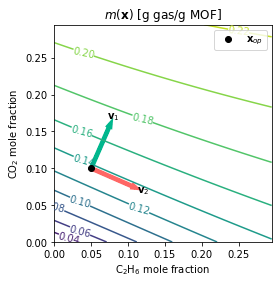

In [120]:
fig, ax = plt.subplots()
# option to show an image
# ims = ax.imshow(M, extent=[x_1[0], x_1[-1], x_2[0], x_2[-1]], 
#                origin='lower',
#                cmap='viridis', alpha=0.5)
# plt.colorbar(ims, label="$m$ [g gas/g MOF]")
CS = ax.contour(X_1, X_2, M, levels=10)# , colors="k")
# plt.colorbar(CS, label="$m$ [g gas/g MOF]")
ax.clabel(CS, inline=True) # labels contours with numbers
ax.set_title("$m(\mathbf{x})$ [g gas/g MOF]")
ax.set_xlabel(gas_to_label[contaminants[0]] + " mole fraction")
ax.set_ylabel(gas_to_label[contaminants[1]] + " mole fraction")
# sketch operating point and directions
plt.scatter(x_op[0], x_op[1], color="k", label="$\mathbf{x}_{op}$", zorder=1000)
sketch_vector(x_op, -v1/15, label="$\mathbf{v}_1$", color=cool_colors["green"])
sketch_vector(x_op, -v2/15, label="$\mathbf{v}_2$", color=cool_colors["red"])
plt.legend()
# plt.plot([x_op[0], x_op[0] - v1[0]/10], [x_op[1], x_op[1] - v1[1]/10], color='k')
# plt.plot([x_op[0], x_op[0] - v2[0]/10], [x_op[1], x_op[1] - v2[1]/10], color='k')
plt.gca().set_aspect('equal', 'box')

## three contaminants

In [28]:
contaminants = ["N2", "CO2", "C2H6"]

discretize composition space

In [29]:
n_pts = 15
max_x = 0.3
X1, X2, X3 = np.mgrid[0:max_x:complex(0,n_pts), 0:max_x:complex(0,n_pts), 0:max_x:complex(0,n_pts)]

store adsorbed mass at each point in a 3D tensor

In [30]:
M = np.zeros(np.shape(X1))
for i in range(n_pts):
    for j in range(n_pts):
        for k in range(n_pts):
            mol_fxns = {"CH4": 1 - (X1[i, j, k] + X2[i, j, k] + X3[i, j, k]), 
                        contaminants[0]: X1[i, j, k], 
                        contaminants[1]: X2[i, j, k], 
                        contaminants[2]: X3[i, j, k]}
            M[i, j, k] = adsorbed_mass(mof, mol_fxns)

define operating point

In [31]:
mol_fxns_op = {"CH4": 0.7, contaminants[0]: 0.05, contaminants[1]: 0.1, contaminants[2]: 0.15}
mol_fxns_op

{'CH4': 0.7, 'N2': 0.05, 'CO2': 0.1, 'C2H6': 0.15}

In [32]:
x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
x_op

array([0.05, 0.1 , 0.15])

In [33]:
m_op = adsorbed_mass(mof, mol_fxns_op)
m_op

0.1583979528174021

compute Jacobian at operating point and find its right singular vectors

In [34]:
J_op = jacobian_matrix_of_m(mof, mol_fxns_op, contaminants)

# right singular vectors
v1, v2, v3 = np.linalg.svd(J_op)[2]
v1, v2, v3

(array([-0.0113151 , -0.92946781, -0.36872965]),
 array([-0.92946781,  0.14575545, -0.33888779]),
 array([-0.36872965, -0.33888779,  0.86555965]))

write to file for visualization in mayavi

In [35]:
np.savez("{}_{}_{}_{}.npz".format(mof, contaminants[0], contaminants[1], contaminants[2]), 
         M=M, X1=X1, X2=X2, X3=X3, v1=v1, v2=v2, v3=v3, x_op=x_op)

# two-MOF sensor array for three contaminants
define the two MOFs and the three contaminants

In [122]:
mofs = ["HKUST-1", "Co-MOF-74"]
contaminants = ["N2", "CO2", "C2H6"]

define an operating point

In [123]:
mol_fxns_op = {"CH4": 0.7, contaminants[0]: 0.05, contaminants[1]: 0.1, contaminants[2]: 0.15}
mol_fxns_op

{'CH4': 0.7, 'N2': 0.05, 'CO2': 0.1, 'C2H6': 0.15}

In [124]:
x_op = mol_fxns_to_x(mol_fxns_op, contaminants)
x_op

array([0.05, 0.1 , 0.15])

In [125]:
m_op = [adsorbed_mass(mof, mol_fxns_op) for mof in mofs]
m_op

[0.07226043704997846, 0.1583979528174021]

compute the Jacobian matrix at the operating point

In [126]:
J_op = [jacobian_matrix_of_m(mof, mol_fxns_op, contaminants) for mof in mofs]
J_op = np.reshape(J_op, (2, 3))

compute the right singular vectors of the Jacobian matrix

In [127]:
# right singular vectors
v1, v2, v3 = np.linalg.svd(J_op)[2]
v1, v2, v3

(array([0.00331137, 0.88202911, 0.47118329]),
 array([ 0.07101382,  0.46978885, -0.87991788]),
 array([ 0.99746984, -0.03637426,  0.06108061]))

for drawing arrows in 3D

In [128]:
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, muh_label, label_stretch, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
    dd = np.array([x+dx, y+dy, z+dz])
    dd = dd / np.linalg.norm(dd)

    ax.text(x+dx+label_stretch*dd[0], y+dy+label_stretch*dd[1], z+dz+label_stretch*dd[2], muh_label, ha="center", va="center")

setattr(Axes3D, 'arrow3D', _arrow3D)

def sketch_vector(x0, x, label=None, dx_mag=0.1):
    plt.arrow(x0[0], x0[1], x[0], x[1], color="k", head_width=0.5, length_includes_head=True, lw=2)
    dx = dx_mag * x / np.linalg.norm(x)
    plt.text(x0[0] + x[0] + dx[0], x0[1] + x[1] + dx[1], label, ha="center", va="center")

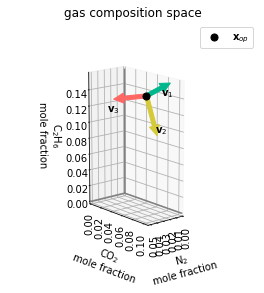

In [148]:
r = 0.05

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.xticks(rotation=90)
plt.yticks(rotation=90)
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.tick_params(axis="z", pad=10)
ax.set_xlabel(gas_to_label[contaminants[0]] + "\nmole fraction", labelpad=16) 
ax.set_ylabel(gas_to_label[contaminants[1]] + "\nmole fraction", labelpad=22) 
ax.set_zlabel(gas_to_label[contaminants[2]] + "\nmole fraction", labelpad=35) 
       
ax.set_title("gas composition space")

ax.scatter(x_op[0], x_op[1], x_op[2], color="k", s=50, label="$\mathbf{x}_{op}$")
v_labels = ["$\mathbf{v}_1$", "$\mathbf{v}_2$", "$\mathbf{v}_3$"]
v_label_stretches = [-0.02, 0.02, -0.02]

for (i, v) in enumerate([v1, v2, v3]):
    color = "k"
    if i == 2:
        color = cool_colors["red"]
    if i == 0:
        color = cool_colors["green"]
    if i == 1:
        color = cool_colors["yellow"]
    ax.arrow3D(x_op[0], x_op[1], x_op[2],
               r*v[0], r*v[1], r*v[2],
               v_labels[i],
               v_label_stretches[i],
               mutation_scale=20,
               ec=color,
               fc=color)
# https://github.com/matplotlib/matplotlib/issues/17172

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_zlim(zmin=0)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])

ax.legend()
ax.view_init(elev=15., azim=50)

plt.plot([0, ax.get_xlim()[1]], [0, 0], [0, 0], c="grey", zorder=1)
plt.plot([0, 0], [0, ax.get_ylim()[1]], [0, 0], c="grey", zorder=1)
plt.plot([0, 0], [0, 0], [0, ax.get_zlim()[1]], c="grey", zorder=1)
ax.dist = 15

plt.tight_layout()
plt.savefig("two_mof_composition_space.pdf", format="pdf")
plt.show()